# Using new numbers from Steve 5-18 2017  
(e.g. horizontal and amacrine space constants)  
Amacrine cell 80 ± 18 µm (mean ± sd)  
Horizontal cell 116  ±  35  
Bipolar cell SNR 7.1 ± 5

In [1]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import collections
from functools import partial
from os.path import expanduser
from tqdm import tqdm
import h5py

from surround.image_processing import *
from surround.data_handling import *
from surround.efficient_coding import *
from aesthetics.plotting import *
from surround.modeling import gaussian, difference_of_gaussians

import pyret.filtertools as ft
from sklearn.decomposition import PCA
from scipy.stats import sem
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d
from scipy.stats import pearsonr

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import convolve2d
import datetime

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

plt.style.use('deepretina')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
todays_date = str(datetime.date.today())
print(todays_date)

2017-06-27


In [3]:
microns_per_degree = 50.0 # depends on species; this is for salamander
photoreceptor_width = 10.0/microns_per_degree # salamander photoreceptors have width of 10-20 microns
retina_width = 4000.0/microns_per_degree # salamander retina is about 4 mm
frequency_spacing = 1./retina_width # this is the lowest non-DC frequency we can estimate
highest_frequency = 0.5/photoreceptor_width # this is the highest frequency we can estimate (Nyquist freq.)

N = int(retina_width//photoreceptor_width)
freqs = np.linspace(0, highest_frequency, N//2 + 1)
space = np.concatenate([np.linspace(-0.5*retina_width, 0, N//2 + 1)[:-1], np.linspace(0, 0.5*retina_width, N//2 + 1)])

### Load receptive fields

In [4]:
# These are loaded as (space, receptive) field tuples
cells = {}
cells['ganglion'] = load_ganglion_cells(space_mode='peak')
cells['bipolar'] = load_bipolar_cells(space_mode='peak')
cells['amacrine'] = load_amacrine_cells(space_mode='peak')
cells['horizontal'] = load_horizontal_cells(space_mode='peak')

In [5]:
receptive_fields = collections.defaultdict(list)
for c in cells.keys():
    for s, rf in cells[c]:
        this_cell_interp = interp1d(s, rf, kind='slinear', bounds_error=False, fill_value=[0])
        receptive_fields[c].append(this_cell_interp(space))
        
average_ganglion_rf = np.mean(receptive_fields['ganglion'], axis=0)

David's 1721 receptive field dataset

In [6]:
data_path = expanduser('~/data/kastner/receptive_fields/')
spatialDelta = 0.05 # mm
micronsPerDeg = 50.
ganglion_rfs = {
    'fast_on': np.loadtxt(data_path + 'linesRF1.txt').reshape((126, 101, -1)),
    'fast_off_adapting': np.loadtxt(data_path + 'linesRF19.txt').reshape((-1, 101, 96)),
    'fast_off_sensitizing': np.loadtxt(data_path + 'linesRF8.txt').reshape((-1, 101, 96)),
    'medium_off_adapting': np.loadtxt(data_path + 'linesRF29.txt').reshape((-1, 101, 96)),
    'slow_off': np.loadtxt(data_path + 'linesRF17.txt').reshape((-1, 101, 96)),
}

for celltype in ganglion_rfs.keys():
    for rf in ganglion_rfs[celltype]:
        # since receptive fields are noisy, use PCA
        pca = PCA(n_components=2)
        pca.fit(rf)
        g_pca = pca.components_[0]

        sign_of_pc = -1 * np.sign(g_pca[abs(g_pca) == np.max(abs(g_pca))])
        this_space = get_space(g_pca, spatialDelta, micronsPerDeg, kind='peak')
        
        rf_interp = interp1d(this_space, sign_of_pc*g_pca, kind='slinear', bounds_error=False, fill_value=[0])

        receptive_fields[celltype].append(rf_interp(space))

### Remove duplicates

In [7]:
corr_map = {}
for celltype in receptive_fields.keys():
    corr_map[celltype] = np.zeros((len(receptive_fields[celltype]), len(receptive_fields[celltype])))
    for idr1, rf1 in tqdm(enumerate(receptive_fields[celltype])):
        for idr2 in range(idr1+1, len(receptive_fields[celltype])):
            rf2 = receptive_fields[celltype][idr2]
            corr_map[celltype][idr1, idr2] = pearsonr(rf1, rf2)[0]

unduplicated_receptive_fields = collections.defaultdict(list)
duplicates = collections.defaultdict(list)

for celltype in corr_map.keys():
    these_dups = []
    for row in corr_map[celltype]:
        these_dups.append([i for i in range(len(row)) if row[i] == 1.0])
    duplicates[celltype] = np.unique(np.hstack(these_dups))
    
unduplicated_receptive_fields = collections.defaultdict(list)
for celltype in receptive_fields.keys():
    for idr, rf in enumerate(receptive_fields[celltype]):
        if idr not in duplicates[celltype]:
            unduplicated_receptive_fields[celltype].append(rf)
            
receptive_fields = unduplicated_receptive_fields.copy()
del unduplicated_receptive_fields

2it [00:00, 5053.38it/s]
2it [00:00, 13273.11it/s]
772it [00:19, 38.73it/s] 
249it [00:02, 121.48it/s]
126it [00:00, 239.62it/s]
321it [00:03, 94.47it/s] 
28it [00:00, 1098.05it/s]
2it [00:00, 15391.94it/s]
253it [00:02, 117.48it/s]


In [8]:
sum([len(receptive_fields[k]) for k in receptive_fields.keys()]) - sum([len(receptive_fields[k]) for k in ['horizontal',
                                                                                                           'amacrine',
                                                                                                          'bipolar']])

1382

### Compute projective fields

In [9]:
horz_pfs_full = get_horizontal_projective_field(conv_mode='full')
horz_pfs_same = get_horizontal_projective_field(conv_mode='same')
ama_pfs_full = get_amacrine_projective_field(conv_mode='full')
ama_pfs_same = get_amacrine_projective_field(conv_mode='same')

space_h_full, horz_pf_full, horz_sem_full = get_mean(horz_pfs_full)
space_h_same, horz_pf_same, horz_sem_same = get_mean(horz_pfs_same)
space_a_full, ama_pf_full, ama_sem_full = get_mean(ama_pfs_full)
space_a_same, ama_pf_same, ama_sem_same = get_mean(ama_pfs_same)

In [10]:
horz_pf_interp = interp1d(space_h_full, horz_pf_full, kind='slinear', bounds_error=False, fill_value=[0])
ama_pf_interp = interp1d(space_a_full, ama_pf_full, kind='slinear', bounds_error=False, fill_value=[0])

horz_pf = horz_pf_interp(space)
ama_pf = ama_pf_interp(space)

### Signal

In [11]:
# choose an image path from cd13A (flood plain, water, horizon) or cd01A (baboons, trees, bushes)
pixelsToDeg = 92./2 # or 2./92 degrees per pixel (spacing)
spacing = 1./pixelsToDeg # number of degree spacing between pixels
normalize = 'divisive'
contrast = 0.35
signal = np.array(np.load('signal_3_23.npy'))

### Noise  
Note that the amplitude of the average_ganglion_fft will change the SNR. As the amplitude $\rightarrow \infty$, we get $$\rm{SNR} \rightarrow \frac{\sum (\rm{filter}_{1:f} \times \rm{signal}_{1:f})^2}{\sum (\rm{filter}_{1:f} \times N_{\rm{in}})^2}$$.  

Since the scale of the ganglion fft is arbitrary, we can look at the SNR in this limit.

In [12]:
input_noise = 0.0469253741641 #0.098762200628786892
output_noise = 0.35
target_power = 48.053365503112332 #54.131410989171826

8.53019238991


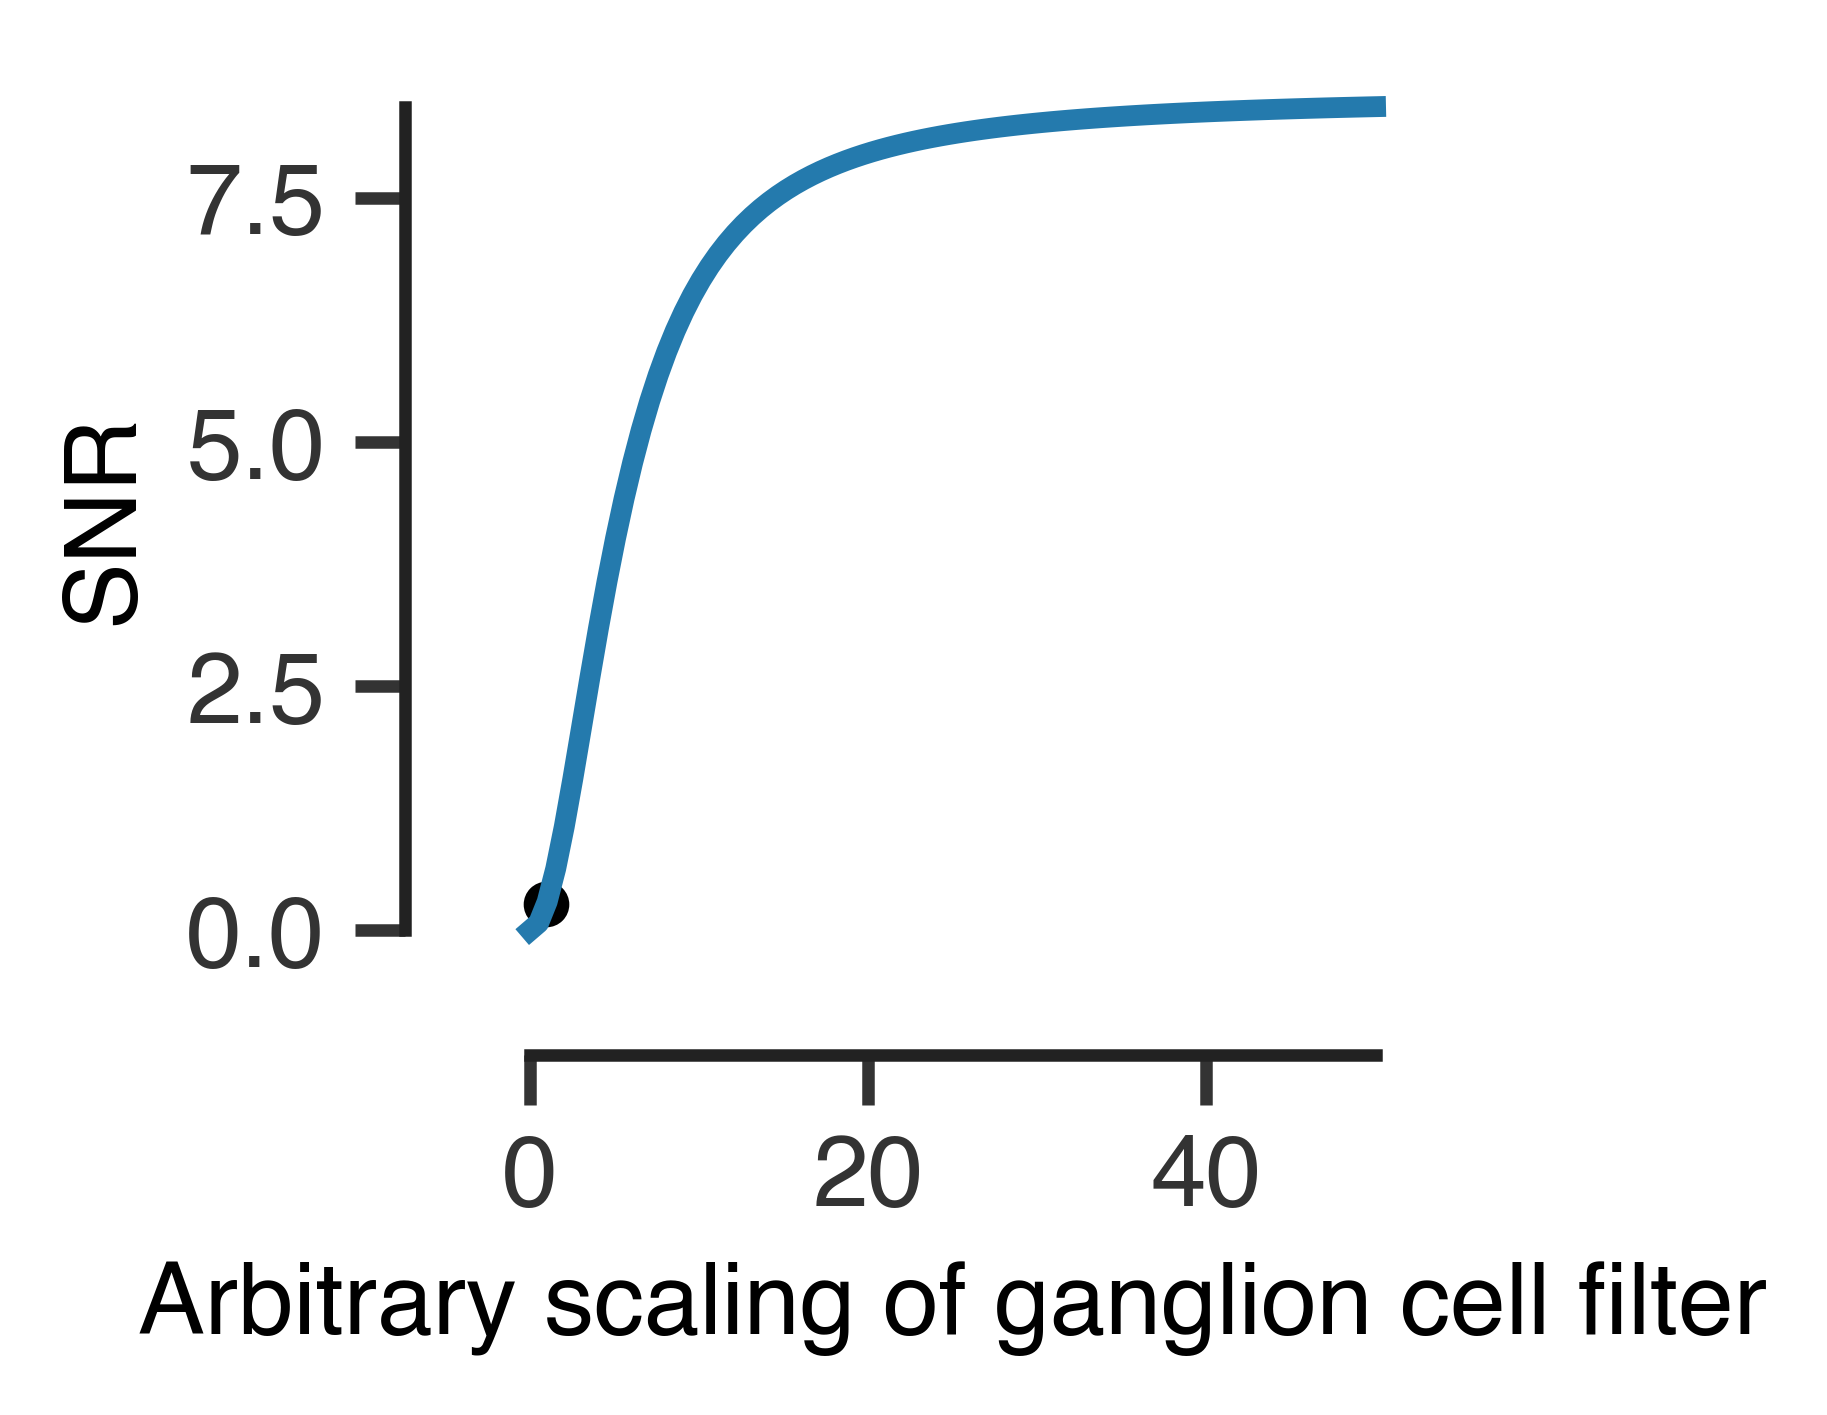

In [13]:
fig = plt.gcf()
fig.set_size_inches((2,2))
average_ganglion_fft = abs(np.fft.rfft(average_ganglion_rf))
print(get_snr(input_noise, output_noise, signal, 1000*average_ganglion_fft, mode='variance'))
snrs = [get_snr(input_noise, output_noise, signal, c*average_ganglion_fft) for c in np.linspace(0,50,100)]
plt.plot(np.linspace(0,50,100), snrs)
adjust_spines(plt.gca())
plt.xlabel('Arbitrary scaling of ganglion cell filter')
plt.ylabel('SNR')

# SNR = 0.269 is total SNR from ganglion recordings of 112 repeats to 30 seconds natural scenes
def find_filt_const(filt_const):
    this_snr = get_snr(input_noise, output_noise, signal, filt_const*average_ganglion_fft, mode='variance')
    return (this_snr - 0.26912469)**2

filt_const_opt = scipy.optimize.minimize_scalar(find_filt_const)

our_snr = get_snr(input_noise, output_noise, signal, filt_const_opt.x*average_ganglion_fft, mode='variance')

plt.scatter(filt_const_opt.x, our_snr, s=20, color='k')

### Ideal filter

In [14]:
ideal_filter = unique_soln(signal**2, input_noise, output_noise)

The relative error from this choice of Lagrangian multiplier is 9.3181295214e-08.


### Model of Horizontal Projective Field + Amacrine Projective Field + Center

In [15]:
horz_pf /= np.sum(horz_pf)
ama_pf /= np.sum(ama_pf)

### Just a simple difference of Gaussians fit to get the initialization point for center width, and the mean center width to find the ideal fit

Get center widths for each celltype

In [16]:
diff_of_gauss_mu0 = partial(difference_of_gaussians, mu=0)

In [ ]:
def center_and_surround(space, center_width, surround_width, center_strength, surround_strength):
    return diff_of_gauss_mu0(space, abs(center_width), abs(surround_width),
                            -abs(center_strength), abs(surround_strength))

In [ ]:
center_widths = collections.defaultdict(list)
surround_widths = collections.defaultdict(list)
center_strengths = collections.defaultdict(list)
surround_strengths = collections.defaultdict(list)
fit_failures = collections.defaultdict(list)

for celltype in receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']:
        
        for idg, g in tqdm(enumerate(receptive_fields[celltype])):
            try:
                popt_this, pcov = curve_fit(center_and_surround, space, g, p0=[1.5, 3.5, -10, 30])
                center_id = np.argmin(abs(popt_this[:2]))
                surround_id = 1 ^ center_id
                center_widths[celltype].append(abs(popt_this[center_id]))
                surround_widths[celltype].append(abs(popt_this[surround_id]))
                center_strengths[celltype].append(popt_this[center_id+2])
                surround_strengths[celltype].append(popt_this[surround_id+2])
#                 plt.plot(space, diff_of_gauss_mu0(space, *popt_this), color=np.random.rand(3), alpha=0.6)
            except:
                fit_failures[celltype].append(idg)
            
                # just set params to median across cells
                # this way the params are still aligned with the receptive field id
                center_widths[celltype].append(np.median(center_widths[celltype]))
                surround_widths[celltype].append(np.median(surround_widths[celltype]))
                center_strengths[celltype].append(np.median(center_strengths[celltype]))
                surround_strengths[celltype].append(np.median(surround_strengths[celltype]))
                
#                 print("Couldn't fit cell %d" %idg)

772it [01:36, 11.06it/s]
46it [00:07,  4.25it/s]

In [ ]:
for f in fit_failures.keys():
    print("couldn't fit %d in %s" %(len(fit_failures[f]), f))

Plot the average profile across celltypes

In [ ]:
median_center_widths = {}
for celltype in center_widths.keys():
    cws = np.array(center_widths[celltype])
    sws = np.array(surround_widths[celltype])
    css = np.array(center_strengths[celltype])
    sss = np.array(surround_strengths[celltype])
#     mean_center_widths[celltype] = np.mean(cws[cws < 500])
#     mean_surround_width = np.mean(sws[sws < 500])
#     mean_center_strength = np.mean(css[abs(css) < 500])
#     mean_surround_strength = np.mean(sss[abs(sss) < 500])
    
    median_center_widths[celltype] = np.median(abs(cws))
    median_surround_width = np.median(abs(sws))
    median_center_strength = np.median(-abs(css))
    median_surround_strength = np.median(abs(sss))
#     plt.plot(space, diff_of_gauss_mu0(space, median_center_widths[celltype], median_surround_width,
#                                      median_center_strength, median_surround_strength), label=celltype)
# plt.legend(frameon=False, fontsize=9, loc='lower left')
# adjust_spines(plt.gca())

In [ ]:
median_center_widths

Bar charts to visualize diversity

## Generate info maps

In [ ]:
resolution = 150
horz_weights = np.linspace(0,1,resolution)
center_weights = np.linspace(0,1,resolution)

In [ ]:
init_filt_const = 10.9
info_maps = collections.defaultdict(list) # one info map per celltype (since they will be a function of center width)
failures = collections.defaultdict(list)
detailed_failures = collections.defaultdict(list)
for celltype in receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']:
        center = gaussian(x=space, sigma=median_center_widths[celltype], mu=0.)
        center /= -np.sum(center) # make center unit vector like horz_pf and ama_pf
        
        def rf_model(horz_weight, center_weight):
            return center_weight*center + (1-center_weight)*(horz_weight*horz_pf + (1-horz_weight)*ama_pf)
        
#         print('Information map for %s cells.' %celltype)
        
        infomap = np.zeros((resolution, resolution))
        for idh,hw in tqdm(enumerate(horz_weights)):
            for idc,cw in enumerate(center_weights):
                rf = rf_model(hw, cw)
                rf_filt = abs(np.fft.rfft(rf))
                
                # constrain model
                def constrain_filt_power(filt_const):
                    size = len(rf_filt)
                    output_power = np.sum((signal*filt_const*rf_filt)**2 
                                          + (input_noise*filt_const*rf_filt)**2
                                          + output_noise**2)
                    
                    return (target_power - output_power)**2

                filt_const_opt = scipy.optimize.minimize(constrain_filt_power, init_filt_const)
                iterations = 0
                new_init_filt_const = init_filt_const
                while not filt_const_opt.success:
                    iterations += 1
                    new_init_filt_const *= 10
                    filt_const_opt = scipy.optimize.minimize(constrain_filt_power, new_init_filt_const)
                    if iterations > 10:
                        detailed_failures[celltype] = filt_const_opt
                        break
                
                filt_const = abs(filt_const_opt['x'])
                
                if not filt_const_opt.success:
                    failures[celltype].append([hw, cw])

                signal_power = (filt_const * rf_filt * signal)**2
                noise_power = (filt_const * rf_filt * input_noise)**2 + output_noise**2
                infomap[idh,idc] = 0.5*np.sum(np.log2(1 + signal_power/noise_power))
        info_maps[celltype] = infomap

## Fit cells to rf_model

In [ ]:
colorscheme = {
    'ganglion': 'k',
    'fast_off_sensitizing': 'r',
    'fast_off_adapting': 'g',
    'slow_off': 'y',
    'fast_on': 'b',
    'medium_off_adapting': 'c'
}

In [ ]:
info_maps.keys()

## Load receptive field model fits

In [ ]:
def sigmoid(x):
    return 1./(1. + np.exp(-x))

In [ ]:
fits = np.load('fits_2017-05-20.npy').item()
all_params = np.load('params_2017-05-20.npy').item()
variances = np.load('variances_2017-05-20.npy').item()
mean_squared_errors = np.load('mse_2017-05-20.npy').item()
abs_errors = np.load('abserrs_2017-05-20.npy').item()

In [ ]:
info_maps['fast_off_adapting'].max()

In [ ]:
info_maps['fast_on'].max()

In [ ]:
global_celltype = 'fast_on'#'medium_off_adapting' #'fast_off_adapting'
point_size = 7 #10
min_info = np.min(info_maps[global_celltype])
max_info = np.max(info_maps[global_celltype])
empirical_ideal_indices = np.unravel_index(np.argmax(info_maps[global_celltype]), info_maps[global_celltype].shape)
empirical_ideal = [horz_weights[empirical_ideal_indices[0]], center_weights[empirical_ideal_indices[1]]]

########## for quivers #########
all_fits = []
for celltype in fits.keys():
    all_fits.extend(fits[celltype])
    
pca = PCA(n_components=2)
pca.fit(all_fits)

# flipping the dimensions because fits was saved as horz_weight, center_weight
average_variance_direction = abs(np.array([pca.components_[0][1], pca.components_[0][0]]))
print('PC1 has explained variance %0.2f%% percent for all cells' %(pca.explained_variance_ratio_[0]*100))

max_info_coordinates = collections.defaultdict(list)
least_info_directions = collections.defaultdict(list)
for celltype in info_maps.keys():
    for x in range(info_maps[celltype].shape[0]):
        for y in range(info_maps[celltype].shape[1]):
            # take cloud of high efficiency points
            if info_maps[celltype][x,y] >= 0.9*max_info:
                max_info_coordinates[celltype].append([horz_weights[x], center_weights[y]])
    pca = PCA()
    pca.fit(max_info_coordinates[celltype])
    print('PC1 has explained variance %0.2f%% percent for %s' %(pca.explained_variance_ratio_[0]*100, celltype))
    least_info_directions[celltype] = abs(pca.components_[-1])
    
average_least_info_direction = np.mean([least_info_directions[k] for k in least_info_directions.keys()], axis=0)
############ end quivers ###########

plt.imshow(info_maps[global_celltype], extent=(center_weights[0], center_weights[-1], horz_weights[-1], horz_weights[0]),
              aspect='auto', clim=[min_info, max_info])
cbar = plt.colorbar()
# cbar.set_ticks([6,7,8,9])
cbar.set_ticks([6, 8, 10, 12, 14])
# plt.clim(0,np.max(info_color_map))
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)

for idc, celltype in enumerate([k for k in info_maps.keys() if k != 'ganglion']):
    # make the points lying on the edges more visible
    adjusted_fits1 = np.where(fits[celltype] == 1, 0.995, fits[celltype])
    adjusted_fits = np.where(adjusted_fits1 < 0.001, 0.005, adjusted_fits1)
    plt.scatter(adjusted_fits[:,1], adjusted_fits[:,0],
                c=colorscheme[celltype], edgecolor='w', s=point_size, alpha=0.5, label=' '.join(celltype.split('_')),
                linewidth=0.3)
#     plt.scatter(adjusted_fits[example_ids[celltype]][:nexamples_for_this_plot,1],
#                adjusted_fits[example_ids[celltype]][:nexamples_for_this_plot,0],
#                c=colorscheme[celltype], edgecolor='k', s=60, marker='*', linewidth=0.7)


# plt.quiver(ideal_fit[1], ideal_fit[0], average_variance_direction[0], average_variance_direction[1],
#            angles='xy', scale_units='xy', scale=2.5, color='k', edgecolor='w', width=0.012, linewidth=1,
#           alpha=0.9)
# plt.quiver(ideal_fit[1], ideal_fit[0], average_least_info_direction[0], average_least_info_direction[1],
#            angles='xy', scale_units='xy', scale=2.5, color='w', edgecolor='k',
#           alpha=0.7, width=.012, linewidth=1.2)
# plt.scatter(ideal_fit[1], ideal_fit[0], c='k', edgecolor='k', s=150, marker='*', linewidth=0.7)

plt.quiver(empirical_ideal[1], empirical_ideal[0], average_variance_direction[0], average_variance_direction[1],
           angles='xy', scale_units='xy', scale=2.5, color='k', edgecolor='w', width=0.012, linewidth=1,
          alpha=0.9)
plt.quiver(empirical_ideal[1], empirical_ideal[0], average_least_info_direction[0], average_least_info_direction[1],
           angles='xy', scale_units='xy', scale=2.5, color='w', edgecolor='k',
          alpha=0.7, width=.012, linewidth=1.2)
plt.scatter(empirical_ideal[1], empirical_ideal[0], c='k', edgecolor='k', s=150, marker='*', linewidth=0.7)


# l = plt.legend(loc='upper left', frameon=False, fontsize=8)
# for text in l.get_texts():
#     text.set_color("white")
plt.ylim([0,1])
plt.xlim([center_weights[0], center_weights[-1]])


# specify ticks
# plt.xticks([0, 0.25, 0.5, 0.75, 1])
# plt.yticks([0, 0.25, 0.5, 0.75, 1])
majorLocator = MultipleLocator(0.5)
majorFormatter = FormatStrFormatter('%0.1f')
minorLocator = MultipleLocator(0.25)

ax = plt.gca()
ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
ax.xaxis.set_minor_locator(minorLocator)
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)

# plt.title('Total information of various models \n with fitted ganglion cells', fontsize=16)
plt.xlabel('Center (1 - Surround) Weight', fontsize=16)
plt.ylabel('Horizontal (1 - Amacrine) Weight', fontsize=16)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.savefig('%s_Figures for Steve IV.png' %todays_date, transparent=True, dpi=300)

In [ ]:
empirical_ideal_indices

In [ ]:
empirical_ideal

### Quality of fit

In [ ]:
mean_squared_errors.keys()

In [ ]:
bins = np.linspace(0,1,50)
bin_width = np.mean(np.diff(bins))
prev_count = np.zeros_like(bins[:-1])

ax = plt.gca()

for i,celltype in enumerate(mean_squared_errors.keys()):
    if 'ganglion' != celltype:
        rel_error = np.array(mean_squared_errors[celltype])/np.array(variances[celltype])
        ax.vlines(np.median(rel_error), 0, 600, color=colorscheme[celltype], linestyle='--', alpha=0.8, zorder=i)

    
plt.xlabel('Relative error (normalized by filter variance)')
plt.ylabel('Cell count')
# ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.ylim(0,600)

for j,celltype in enumerate(mean_squared_errors.keys()):
    if 'ganglion' != celltype:
        rel_error = np.array(mean_squared_errors[celltype])/np.array(variances[celltype])
        count, bins = np.histogram(rel_error, bins=bins)

#         plt.bar(bins[:-1]+bin_width/2, count, width=bin_width, color=colorscheme[celltype], 
#                 label=' '.join(celltype.split('_')), edgecolor='k', bottom=prev_count, zorder=j+10)

        plt.bar(bins[:-1]+bin_width/2, count, width=bin_width, color=colorscheme[celltype], 
                label=' '.join(celltype.split('_')), bottom=prev_count, zorder=j+10)

#         plt.bar(bins[:-1]+bin_width/2, count, width=bin_width, color=colorscheme[celltype], 
#                 label=' '.join(celltype.split('_')), alpha=0.9, zorder=j+10)
        prev_count += count


plt.legend(loc='upper right', frameon=False, fontsize=9)
plt.savefig('%s_Percent variance explained by model with median.png' %todays_date, transparent=True, dpi=300)

In [ ]:
rel_errors = []
for j,celltype in enumerate(mean_squared_errors.keys()):
    if 'ganglion' != celltype:
        rel_errors.extend(np.array(mean_squared_errors[celltype])/np.array(variances[celltype]))

In [ ]:
print(len(rel_errors))
100.*(1. - np.mean(rel_errors))

In [ ]:
sem(100.*(1. - np.array(rel_errors)))

Correlate the quality of fit with the horz/amacrine fit and the center/surround fit

In [ ]:
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
relative_errors = collections.defaultdict(list)

hw_bins = np.linspace(0,1,10)
cw_bins = np.linspace(0,1,10)

for celltype in sorted(mean_squared_errors.keys(), reverse=True):
    rel_error = np.array(mean_squared_errors[celltype])/np.array(variances[celltype])
    relative_errors[celltype] = rel_error
    
    hw_binned_rel_error = [[err for ide,err in enumerate(rel_error) if np.argmin((fits[celltype][ide,0] - hw_bins)**2) == idb] for idb in range(len(hw_bins))]
    cw_binned_rel_error = [[err for ide,err in enumerate(rel_error) if np.argmin((fits[celltype][ide,1] - cw_bins)**2) == idb] for idb in range(len(cw_bins))]
    avg_hw_rel_error = [np.mean(r) for r in hw_binned_rel_error]
    avg_cw_rel_error = [np.mean(r) for r in cw_binned_rel_error]
    
    # Horizontal weight
    ax1.bar(hw_bins, avg_hw_rel_error, width=np.mean(np.diff(hw_bins)), color=colorscheme[celltype],
               label=' '.join(celltype.split('_')), alpha=0.8)
    ax1.set_ylabel('Relative Error')
    ax1.set_xlabel('Horizontal weight')
    ax1.set_title('Horizontal weight')
    
    ax2.bar(cw_bins, avg_cw_rel_error, width=np.mean(np.diff(cw_bins)), color=colorscheme[celltype],
               label=' '.join(celltype.split('_')), alpha=0.8)
    ax2.set_ylabel('Relative Error')
    ax2.set_xlabel('Center weight')
    ax2.set_title('Center weight')

#ax = plt.gca()
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
                  
# plt.ylim(0,200)
# plt.savefig('%s_Percent variance explained by model with median.png' %todays_date,
#            transparent=True, dpi=300)

In [ ]:
error_threshold = 0.2

In [ ]:
total_number_remaining = 0
total_number_before = 0
for celltype in fits.keys():
    good_fits = float(fits[celltype][relative_errors[celltype] < error_threshold].shape[0])
    all_fits = float(fits[celltype].shape[0])
    print('%f%% of %s' %(100.*good_fits/all_fits, celltype))
    
    total_number_remaining += good_fits
    total_number_before += all_fits

In [ ]:
1.0*total_number_remaining/total_number_before

#### Mapping ideal fit to our parameter space

In [ ]:
global_celltype = 'fast_off_adapting'
iterations = 50

rf = -np.fft.fftshift(np.fft.irfft(ideal_filter))
rf = np.append(rf, rf[-1])

center = gaussian(x=space, sigma=median_center_widths[global_celltype], mu=0.)
center /= -np.sum(center) # make center unit vector like horz_pf and ama_pf

def rf_model(horz_weight, center_weight):
    horz_weight = np.min([1.0, abs(horz_weight)])
    center_weight = np.min([1.0, abs(center_weight)])
    return center_weight*center + (1-center_weight)*(horz_weight*horz_pf + (1-horz_weight)*ama_pf)

def model_error_to_ganglion_cells(weights):
    hw, cw = weights
    modeled_rf = rf_model(hw, cw)
    normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
    return sum(abs(normed_rf - rf))

best_fit_err = np.inf
for itr in range(iterations):
    this_popt = minimize(model_error_to_ganglion_cells, np.random.rand(2))
    if this_popt.fun < best_fit_err:
        best_fit_err = this_popt.fun
        popt = this_popt

# get mean squared error
modeled_rf = rf_model(*popt.x)
normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
mse = np.mean((normed_rf - rf)**2)

# truncate params between 0 and 1
#             x = np.where(popt.x < 0, 0, popt.x) # this actually is wrong, since I'm abs(params) in rf_model
#             x = np.where(x > 1, 1, x)
x = np.where(abs(popt.x) > 1, 1, abs(popt.x))
ideal_fit = x

Pick examples

In [ ]:
fits[celltype][10]

In [ ]:
center_weights[np.argmax(np.max(info_maps[celltype], axis=0))]

In [ ]:
nexamples = 10
example_rfs = collections.defaultdict(list)
example_ids = collections.defaultdict(list)
example_cws = collections.defaultdict(list)

for celltype in receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']: 
        
        rf_ids = np.arange(len(receptive_fields[celltype]))
        schedule = np.random.permutation(rf_ids)
                
        for i in schedule:
            rf = receptive_fields[celltype][i]
#         for i,rf in enumerate(receptive_fields[celltype]):
            x = fits[celltype][i]
                        
            # collect examples
            if len(example_rfs[celltype]) <= nexamples:
                # check if the fit is close to the optimimum center weight
                if abs(x[1] - center_weights[np.argmax(np.max(info_maps[celltype], axis=0))]) < 0.015:
                    example_rfs[celltype].append(rf)
                    example_ids[celltype].append(i)
                    example_cws[celltype].append(x[1])

In [ ]:
nexamples_for_this_plot = 10
# celltype = 'fast_off_adapting'
for ide in range(nexamples_for_this_plot):
    for celltype in example_rfs.keys():
        if len(example_rfs[celltype]) > ide and celltype != 'ganglion':
            ex = example_rfs[celltype][ide]
            if ide == 0:
                plt.plot(space, ex/np.max(abs(ex)), alpha=1-ide/nexamples_for_this_plot, 
                         color=colorscheme[celltype], label=' '.join(celltype.split('_')))
            else:
                plt.plot(space, ex/np.max(abs(ex)), color=colorscheme[celltype])
            
plt.ylim(-1.1, 0.8)
plt.xlabel('Space (degrees)')
plt.ylabel('Normalized sensitivity')
plt.title('Diversity of receptive field model fits')
plt.legend(loc='lower left', frameon=False, fontsize=9)
adjust_spines(plt.gca())
plt.savefig('%s_diversity of receptive fields in space peak with constrained noise.png' %todays_date,
           transparent=True, dpi=300)

In [ ]:
# celltype = 'fast_off_adapting'
for ide in range(nexamples_for_this_plot):
    for celltype in example_rfs.keys():
        if len(example_rfs[celltype]) > ide and celltype != 'ganglion':
            ex = example_rfs[celltype][ide]
            ex_fft = abs(np.fft.rfft(ex))
            if ide == 0:
                plt.plot(freqs, ex_fft/np.max(abs(ex_fft)), alpha=1-ide/nexamples_for_this_plot, 
                         color=colorscheme[celltype], label=' '.join(celltype.split('_')), linewidth=2)
            else:
                plt.plot(freqs, ex_fft/np.max(abs(ex_fft)),
                         color=colorscheme[celltype], linewidth=2)
            
plt.ylim(-0.1, 1.3)
plt.xlim(0.0124, 1.2)
plt.xscale('log')
plt.xlabel('Spatial frequency (degrees$^{-1}$)')
plt.ylabel('Normalized amplitude')
plt.title('Diversity of receptive fields')
plt.legend(loc='upper right', frameon=False, fontsize=9)
adjust_spines(plt.gca())
plt.savefig('%s_diversity of receptive fields in freq logscale peak with constrained noise.png' %todays_date,
           transparent=True, dpi=300)

In [ ]:
example_cws[celltype]

In [ ]:
fits[celltype][example_ids[celltype]][:nexamples_for_this_plot,1]

Note that now I am just displaying the angle difference for a given cell type

In [ ]:
least_info_directions.keys()

In [ ]:
least_info_directions['fast_off_adapting'].shape

In [ ]:
global_celltype = 'fast_on'#'medium_off_adapting' #'fast_off_adapting' #'fast_off_sensitizing'
point_size = 7 #10
min_info = np.min(info_maps[global_celltype])
max_info = np.max(info_maps[global_celltype])
empirical_ideal_indices = np.unravel_index(np.argmax(info_maps[global_celltype]), info_maps[global_celltype].shape)
empirical_ideal = [horz_weights[empirical_ideal_indices[0]], center_weights[empirical_ideal_indices[1]]]

########## for quivers #########
# all_fits = []
variance_directions = {}
for celltype in fits.keys():
#     these_fits = fits[celltype][relative_errors[celltype] < error_threshold]
    
#     all_fits.extend(fits[celltype][relative_errors[celltype] < error_threshold])
    pca = PCA(n_components=2)
    pca.fit(fits[celltype][relative_errors[celltype] < error_threshold])

#     # flipping the dimensions because fits was saved as horz_weight, center_weight
    variance_directions[celltype] = abs(np.array([pca.components_[0][1], pca.components_[0][0]]))
    print('PC1 has explained variance %0.2f%% percent for variance %s' %(pca.explained_variance_ratio_[0]*100, celltype))

average_variance_direction = np.mean(np.stack([variance_directions[k] for k in variance_directions.keys()]), axis=0)
# all_fits = fits[global_celltype][relative_errors[global_celltype] < error_threshold] # COMMENT THIS OUT
    
# pca = PCA(n_components=2)
# pca.fit(all_fits)

# flipping the dimensions because fits was saved as horz_weight, center_weight
# average_variance_direction = abs(np.array([pca.components_[0][1], pca.components_[0][0]]))
# print('PC1 has explained variance %0.2f%% percent for all cells' %(pca.explained_variance_ratio_[0]*100))

max_info_coordinates = collections.defaultdict(list)
least_info_directions = collections.defaultdict(list)
# celltype = global_celltype
for celltype in info_maps.keys():
    for x in range(info_maps[celltype].shape[0]):
        for y in range(info_maps[celltype].shape[1]):
            # take cloud of high efficiency points
            if info_maps[celltype][x,y] >= 0.9*max_info:
                max_info_coordinates[celltype].append([horz_weights[x], center_weights[y]])
    pca = PCA()
    pca.fit(max_info_coordinates[celltype])
    print('PC1 has explained variance %0.2f%% percent for %s' %(pca.explained_variance_ratio_[0]*100, celltype))
    least_info_directions[celltype] = abs(pca.components_[-1])
    
average_least_info_direction = np.mean([least_info_directions[k] for k in least_info_directions.keys()], axis=0)
# average_least_info_direction = least_info_directions[global_celltype] # COMMENT THIS OUT

angle_diff = np.arctan(average_least_info_direction[1]/average_least_info_direction[0]) - np.arctan(average_variance_direction[1]/average_variance_direction[0])
print('Angle difference in radians is %0.4f' %angle_diff)
angle_diff_degs = (360./(2*np.pi))*angle_diff
print('Angle difference in degrees is %0.4f' %angle_diff_degs)
############ end quivers ###########

plt.imshow(info_maps[global_celltype], extent=(center_weights[0], center_weights[-1], horz_weights[-1], horz_weights[0]),
              aspect='auto', clim=[min_info, max_info])
cbar = plt.colorbar()
# cbar.set_ticks([6,7,8,9])
cbar.set_ticks([6, 8, 10, 12, 14])
# plt.clim(0,np.max(info_color_map))
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)

for idc, celltype in enumerate([k for k in info_maps.keys() if k != 'ganglion']):
    # make the points lying on the edges more visible
    adjusted_fits1 = np.where(fits[celltype] == 1, 0.995, fits[celltype])[relative_errors[celltype] < error_threshold]
    adjusted_fits = np.where(adjusted_fits1 < 0.001, 0.005, adjusted_fits1)
    plt.scatter(adjusted_fits[:,1], adjusted_fits[:,0],
                c=colorscheme[celltype], edgecolor='w', s=point_size, alpha=0.5, label=' '.join(celltype.split('_')),
                linewidth=0.3)
    plt.scatter(fits[celltype][example_ids[celltype]][:nexamples_for_this_plot,1],
               fits[celltype][example_ids[celltype]][:nexamples_for_this_plot,0],
               c=colorscheme[celltype], edgecolor='k', s=60, marker='*', linewidth=0.7)


# plt.quiver(ideal_fit[1], ideal_fit[0], average_variance_direction[0], average_variance_direction[1],
#            angles='xy', scale_units='xy', scale=2.5, color='k', edgecolor='w', width=0.012, linewidth=1,
#           alpha=0.9)
# plt.quiver(ideal_fit[1], ideal_fit[0], average_least_info_direction[0], average_least_info_direction[1],
#            angles='xy', scale_units='xy', scale=2.5, color='w', edgecolor='k',
#           alpha=0.7, width=.012, linewidth=1.2)
# plt.scatter(ideal_fit[1], ideal_fit[0], c='k', edgecolor='k', s=150, marker='*', linewidth=0.7)

plt.quiver(empirical_ideal[1], empirical_ideal[0], average_variance_direction[0], average_variance_direction[1],
           angles='xy', scale_units='xy', scale=2.5, color='k', edgecolor='w', width=0.012, linewidth=1,
          alpha=0.9)
plt.quiver(empirical_ideal[1], empirical_ideal[0], average_least_info_direction[0], average_least_info_direction[1],
           angles='xy', scale_units='xy', scale=2.5, color='w', edgecolor='k',
          alpha=0.7, width=.012, linewidth=1.2)
plt.scatter(empirical_ideal[1], empirical_ideal[0], c='k', edgecolor='k', s=150, marker='*', linewidth=0.7)


# l = plt.legend(loc='upper left', frameon=False, fontsize=8)
# for text in l.get_texts():
#     text.set_color("white")
plt.ylim([0,1])
plt.xlim([center_weights[0], center_weights[-1]])


# specify ticks
# plt.xticks([0, 0.25, 0.5, 0.75, 1])
# plt.yticks([0, 0.25, 0.5, 0.75, 1])
majorLocator = MultipleLocator(0.5)
majorFormatter = FormatStrFormatter('%0.1f')
minorLocator = MultipleLocator(0.25)

ax = plt.gca()
ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
ax.xaxis.set_minor_locator(minorLocator)
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)

# plt.title('Total information of various models \n with fitted ganglion cells', fontsize=16)
plt.xlabel('Center (1 - Surround) Weight', fontsize=16)
plt.ylabel('Horizontal (1 - Amacrine) Weight', fontsize=16)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.savefig('%s_Fig3D information map.png' %todays_date, transparent=True, dpi=300)

In [ ]:
np.stack([variance_directions[k] for k in variance_directions.keys()])

In [ ]:
tmp = np.stack([variance_directions[k] for k in variance_directions.keys()])

for x,y in tmp:
    plt.quiver(empirical_ideal[1], empirical_ideal[0], x, y,
               angles='xy', scale_units='xy', scale=2.5, color='k', edgecolor='w', width=0.012, linewidth=1,
              alpha=0.9)
    
plt.quiver(empirical_ideal[1], empirical_ideal[0], average_least_info_direction[0], average_least_info_direction[1],
           angles='xy', scale_units='xy', scale=2.5, color='w', edgecolor='k',
          alpha=0.7, width=.012, linewidth=1.2)

plt.xlim(0,1)
plt.ylim(0,1)

In [ ]:
angle_diff = np.arctan(average_least_info_direction[1]/average_least_info_direction[0]) - np.arctan(average_variance_direction[1]/average_variance_direction[0])
print('Angle difference in radians is %0.4f' %angle_diff)

In [ ]:
angle_diff_degs = (360./(2*np.pi))*angle_diff
print('Angle difference in degrees is %0.4f' %angle_diff_degs)

In [ ]:
fig = plt.gcf()
ax = plt.gca()

# Histogram
bin_edges = np.linspace(0, 1, 30)
bin_width = np.mean(np.diff(bin_edges))
prev_count = np.zeros_like(bin_edges[:-1])
# for c, celltype in enumerate(fits.keys()):
for c, celltype in enumerate(['fast_off_adapting', 'medium_off_adapting', 'slow_off', 'fast_off_sensitizing', 'fast_on']):
    if celltype != 'ganglion':
        this_count, bins = np.histogram(fits[celltype][:, 0][relative_errors[celltype] < error_threshold],
                                        bins=bin_edges)
#         ax.bar(bin_edges[:-1] + bin_width/2, this_count, color=colorscheme[celltype], width=bin_width,
#                bottom=prev_count, linewidth=0.5, label=' '.join(celltype.split(' ')), zorder=c+20)
        ax.bar(bin_edges[:-1] + bin_width/2, this_count, color=colorscheme[celltype], width=bin_width,
               bottom=prev_count, linewidth=0.5, label=' '.join(celltype.split(' ')), zorder=c+20)
#         ax.bar(bin_edges[:-1] + bin_width/2, this_count, color=colorscheme[celltype], width=bin_width,
#                linewidth=0.5, label=' '.join(celltype.split(' ')), alpha=0.9, zorder=c+20)

        prev_count += this_count
        
        plt.vlines(np.median(fits[celltype][:, 0][relative_errors[celltype] < error_threshold]),
                   0, 150, color=colorscheme[celltype], linestyle='--', alpha=0.8, zorder=c)
        
l = plt.legend(frameon=False, fontsize=9, loc='upper right')
for text in l.get_texts():
    splitlabel = text.properties()['text'].split(' ')
    text.set_color(colorscheme['_'.join(splitlabel)])

        

plt.xlim(0,1.007)
# plt.xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_ylabel('# Cells', color='k', fontsize=20)
ax.set_xlabel('Horizontal (1 - Amacrine) Weight')
# ax.set_ylim(0,140)
# ax.set_yticks([0,100,200,300])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['bottom'].set_visible(False)

# ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')



majorLocator = MultipleLocator(50)
majorFormatter = FormatStrFormatter('%d')

ax = plt.gca()
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
# ax.xaxis.set_minor_locator(minorLocator)

# ax.yaxis.set_ticks_position('left')
# adjust_spines(plt.gca())
# plt.xlabel('Center (1 - surround) weight')
# plt.ylabel('# Cells')
plt.savefig('%s_1d y-axis distribution.png' %todays_date, transparent=True, dpi=300)

In [ ]:
# for c, celltype in enumerate(fits.keys()):
for c, celltype in enumerate(['fast_off_sensitizing', 'slow_off', 'fast_on', 'fast_off_adapting',
                             'medium_off_adapting']):
    if celltype != 'ganglion':
        plt.plot(center_weights, info_maps[celltype][75, :], alpha=0.8, color=colorscheme[celltype])
        infos_at_horz_slice = []
        center_weight_fits = np.stack(fits[celltype])[:, 1][relative_errors[celltype] < error_threshold]
        for f in fits[celltype]:
            idx = np.argmin(abs(f[0] - horz_weights))
            idy = np.argmin(abs(f[1] - center_weights))
            infos_at_horz_slice.append(info_maps[celltype][idx, idy])

    #     color = np.random.rand(3)
#         plt.scatter(center_weight_fits, infos_at_horz_slice, color=colorscheme[celltype], 
#                     label=' '.join(celltype.split('_')), s=30, edgecolor='w', lw=0.5)
        plt.vlines(np.median(center_weight_fits), 0, 15, color=colorscheme[celltype], linestyle='--', alpha=0.8)
    
# l = plt.legend(frameon=False, fontsize=9, loc='upper left')
# for text in l.get_texts():
#     splitlabel = text.properties()['text'].split(' ')
#     text.set_color(colorscheme['_'.join(splitlabel)])

plt.ylabel('Information (bits)', fontsize=20)
# adjust_spines(plt.gca())
plt.ylim(0, 14.2)
plt.xlim(0,1.1)
ax1 = plt.gca()
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
ax1.spines['bottom'].set_visible(False)
plt.xticks([])
ax1.set_xlabel('Center (1 - Surround) Weight', fontsize=20)

majorLocator = MultipleLocator(0.5)
majorFormatter = FormatStrFormatter('%0.1f')
minorLocator = MultipleLocator(0.25)

ax = plt.gca()
ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
ax.xaxis.set_minor_locator(minorLocator)

# Histogram
bin_edges = np.linspace(0, 1, 50)
bin_width = np.mean(np.diff(bin_edges))
prev_count = np.zeros_like(bin_edges[:-1])

ax2 = ax1.twinx()
# for c, celltype in enumerate(fits.keys()):
for c, celltype in enumerate(['fast_off_sensitizing', 'slow_off', 'fast_on', 'fast_off_adapting',
                             'medium_off_adapting']):
    if celltype != 'ganglion':
        this_count, bins = np.histogram(np.stack(fits[celltype])[:, 1][relative_errors[celltype] < error_threshold],
                                        bins=bin_edges)
#         ax2.bar(bin_edges[:-1] + bin_width/2, this_count, color=colorscheme[celltype], width=bin_width,
#                bottom=prev_count, linewidth=0.5, edgecolor='k')
        ax2.bar(bin_edges[:-1] + bin_width/2, this_count, color=colorscheme[celltype], width=bin_width,
               bottom=prev_count, linewidth=0.5)
#         ax2.bar(bin_edges[:-1] + bin_width/2, this_count, color=colorscheme[celltype], width=bin_width,
#                linewidth=0.5, alpha=0.85)

        prev_count += this_count

plt.xlim(0,1.007)
# plt.xticks([0, 0.25, 0.5, 0.75, 1])
ax2.set_ylabel('# Cells', color='k', fontsize=20)
ax2.set_ylim(0,340)
ax2.set_yticks([0,100,200,300])

# ax.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.xaxis.set_ticks_position('bottom')

# ax.yaxis.set_ticks_position('left')
# adjust_spines(plt.gca())
# plt.xlabel('Center (1 - surround) weight')
# plt.ylabel('# Cells')
plt.savefig('%s_1d info slice with histogram with constrained noise.png' %todays_date,
           transparent=True, dpi=300)

# Fig 3A

In [ ]:
ffts = []
for rf in receptive_fields['ganglion']:
    this_fft = abs(np.fft.rfft(rf))
    this_fft /= np.max(this_fft)
    ffts.append(this_fft)

# avg_rf = np.mean(receptive_fields['ganglion'], axis=0)
# avg_rf_fft = abs(np.fft.rfft(avg_rf))
# plt.plot(freqs, avg_rf_fft)

sems = sem(np.stack(ffts))
stds = np.std(np.stack(ffts), axis=0)
avg_rf_fft = abs(np.mean(np.stack(ffts), axis=0))
avg_rf_fft2 = np.mean(abs(np.stack(ffts)), axis=0)

plt.errorbar(freqs, avg_rf_fft/np.max(avg_rf_fft), yerr=sems/np.max(avg_rf_fft), color='g')
plt.errorbar(freqs, avg_rf_fft2/np.max(avg_rf_fft2), yerr=sems/np.max(avg_rf_fft2), color='c')
# plt.errorbar(freqs, avg_rf_fft2/np.max(avg_rf_fft2), yerr=stds/np.max(avg_rf_fft2), color='y')
plt.plot(freqs, ideal_filter/np.max(ideal_filter), color='k')
plt.plot(freqs, signal/np.max(signal), 'r')
plt.xlim(0, 0.3)

# Distribution of % efficiency

In [ ]:
target_power = 5e1
init_filt_const = 0.29
info_rfs = collections.defaultdict(list)
info_rf_models = collections.defaultdict(list)
mses_verify = collections.defaultdict(list)
filt_consts_rfs = collections.defaultdict(list)
filt_consts_models = collections.defaultdict(list)

failures_rf = collections.defaultdict(list)
detailed_failures_rf = collections.defaultdict(list)
failures_model = collections.defaultdict(list)
detailed_failures_model = collections.defaultdict(list)

for celltype in receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']:
        for idrf,rf in tqdm(enumerate(receptive_fields[celltype])):
            ###### compute information of actual cell ######
            rf_filt = abs(np.fft.rfft(rf))
            
            def constrain_filt_power(filt_const):
                size = len(rf_filt)
                output_power = np.sum((signal*filt_const*rf_filt)**2 
                                      + (input_noise*filt_const*rf_filt)**2
                                      + output_noise**2)
                return (target_power - output_power)**2

            filt_const_opt = scipy.optimize.minimize(constrain_filt_power, init_filt_const)
            iterations = 0
            new_init_filt_const = init_filt_const
            while filt_const_opt.fun > 10e2:
                iterations += 1
                new_init_filt_const = np.random.rand()
                filt_const_opt = scipy.optimize.minimize(constrain_filt_power, new_init_filt_const)
                if iterations > 20:
                    detailed_failures_rf[celltype] = filt_const_opt
                    break

            filt_const = abs(filt_const_opt['x'])
            filt_consts_rfs[celltype].append(filt_const)
            if not filt_const_opt.success:
                failures_rf[celltype].append(idrf)

            signal_power = (filt_const * rf_filt * signal)**2
            noise_power = (filt_const * rf_filt * input_noise)**2 + output_noise**2
            info_rfs[celltype].append(0.5*np.sum(np.log2(1 + signal_power/noise_power)))
                
            ###### compute information of rf model ######    
            center = gaussian(x=space, sigma=center_widths[celltype][idrf], mu=0.)
            center /= -np.sum(center) # make center unit vector like horz_pf and ama_pf
            horz_weight, center_weight = fits[celltype][idrf]
        
            def rf_model(horz_weight, center_weight):
                horz_weight = np.min([1.0, abs(horz_weight)])
                center_weight = np.min([1.0, abs(center_weight)])
                return center_weight*center + (1-center_weight)*(horz_weight*horz_pf + (1-horz_weight)*ama_pf)
            
            def model_error_to_ganglion_cells(weights):
                hw, cw = weights
                modeled_rf = rf_model(hw, cw)
                normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
                return sum(abs(normed_rf - rf))
            
            # get mean squared error
            modeled_rf = rf_model(horz_weight, center_weight)
            normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
            mse = np.mean((normed_rf - rf)**2)
            mses_verify[celltype].append(mse)
            
            rf_filt = abs(np.fft.rfft(modeled_rf))
     
            # constrain model
            def constrain_filt_power(filt_const):
                size = len(rf_filt)
                output_power = np.sum((signal*filt_const*rf_filt)**2 
                                      + (input_noise*filt_const*rf_filt)**2
                                      + output_noise**2)

                return (target_power - output_power)**2

            filt_const_opt = scipy.optimize.minimize(constrain_filt_power, init_filt_const)
            iterations = 0
            new_init_filt_const = init_filt_const
            while not filt_const_opt.success:
                iterations += 1
                new_init_filt_const *= 10
                filt_const_opt = scipy.optimize.minimize(constrain_filt_power, new_init_filt_const)
                if iterations > 10:
                    detailed_failures_model[celltype] = filt_const_opt
                    break

            filt_const = abs(filt_const_opt['x'])
            filt_consts_models[celltype].append(filt_const)

            if not filt_const_opt.success:
                failures_model[celltype].append([hw, cw])

            signal_power = (filt_const * rf_filt * signal)**2
            noise_power = (filt_const * rf_filt * input_noise)**2 + output_noise**2
            info_rf_models[celltype].append(0.5*np.sum(np.log2(1 + signal_power/noise_power)))

In [ ]:
all_info_rfs = []
all_info_rf_models = []
for celltype in info_maps.keys():
    if celltype != 'ganglion':
        all_info_rfs.extend(info_rfs[celltype])
        all_info_rf_models.extend(info_rf_models[celltype])

bins_2d = np.linspace(np.min([np.min(all_info_rfs), np.min(all_info_rf_models)]),
                     np.max([np.max(all_info_rfs), np.max(all_info_rf_models)]),
                     10)
count, xedges, yedges = np.histogram2d(all_info_rfs, all_info_rf_models, bins=[bins_2d, bins_2d])
plt.imshow(count.T, cmap='gray_r', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower')
cbar = plt.colorbar()
cbar.ax.set_ylabel('# cells')

# contours
bins_contours = np.linspace(np.min([np.min(all_info_rfs), np.min(all_info_rf_models)]),
                     np.max([np.max(all_info_rfs), np.max(all_info_rf_models)])+.5,
                     11)
for celltype in info_maps.keys():
    if celltype != 'ganglion':
        H, xedges_contour, yedges_contour = np.histogram2d(info_rfs[celltype], info_rf_models[celltype],
                                            bins=[bins_contours, bins_contours])
        bar_width = np.mean(np.diff(xedges_contour))
        X, Y = np.meshgrid(xedges_contour[:-1] + bar_width/2, yedges_contour[:-1] + bar_width/2)
        cs = plt.contour(X, Y, H, 1, linewidths=1.7, alpha=0.95, colors=colorscheme[celltype], label=celltype)
        print('%0.4f percent (%d cells) of celltype %s (%s)' %(cs.levels/len(info_rfs[celltype]), cs.levels,
                                                               celltype, colorscheme[celltype]))

    
# for celltype in davids_celltypes:
#     plt.scatter(info_rfs[celltype], info_rf_models[celltype], c=colorscheme[celltype], edgecolor='w',
#                label=' '.join(celltype.split('_')), s=10, linewidth=.5, alpha=0.5)

plt.plot(np.linspace(5, 16, 10), np.linspace(5, 16, 10), 'k--')
plt.xlabel('Information for RFs (bits)')
plt.ylabel('Information for RF Models (bits)')
# plt.legend(loc=(-0.01, 0.4), frameon=False, fontsize=9)
plt.xlim(5, xedges[-1])
plt.ylim(5, xedges[-1])
# plt.yticks(sorted(np.unique(xedges.astype(int)))[1:])
# plt.xticks(sorted(np.unique(xedges.astype(int)))[1:])
# plt.yticks([6, 7, 8, 9, 10])
# plt.xticks([6, 7, 8, 9, 10])
adjust_spines(plt.gca())
plt.savefig('%s_rf_model_vs_rf_info constrained noise without examples with 10 bins contours rerun.png' %todays_date,
           transparent=True, dpi=300)

In [ ]:
all_info_rfs = []
all_info_rf_models = []
for celltype in info_maps.keys():
    if celltype != 'ganglion':
        all_info_rfs.extend(info_rfs[celltype])
        all_info_rf_models.extend(info_rf_models[celltype])

bins_2d = np.linspace(np.min([np.min(all_info_rfs), np.min(all_info_rf_models)]),
                     np.max([np.max(all_info_rfs), np.max(all_info_rf_models)]),
                     10)
count, xedges, yedges = np.histogram2d(all_info_rfs, all_info_rf_models, bins=[bins_2d, bins_2d])
plt.imshow(count.T, cmap='gray_r', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower')
cbar = plt.colorbar()
cbar.ax.set_ylabel('# cells')

# contours
bins_contours = np.linspace(np.min([np.min(all_info_rfs), np.min(all_info_rf_models)]),
                     np.max([np.max(all_info_rfs), np.max(all_info_rf_models)])+.5,
                     11)
for celltype in info_maps.keys():
    if celltype != 'ganglion':
#         H, xedges_contour, yedges_contour = np.histogram2d(info_rfs[celltype], info_rf_models[celltype],
#                                             bins=[bins_contours, bins_contours])
#         bar_width = np.mean(np.diff(xedges_contour))
#         X, Y = np.meshgrid(xedges_contour[:-1] + bar_width/2, yedges_contour[:-1] + bar_width/2)
#         cs = plt.contour(X, Y, H, 1, linewidths=1.7, alpha=0.95, colors=colorscheme[celltype], label=celltype)
#         print('%0.4f percent (%d cells) of celltype %s (%s)' %(cs.levels/len(info_rfs[celltype]), cs.levels,
#                                                                celltype, colorscheme[celltype]))
        
        plt.errorbar(np.mean(info_rfs[celltype]), np.mean(info_rf_models[celltype]),
                    yerr=sem(info_rf_models[celltype]), xerr=sem(info_rfs[celltype]), color=colorscheme[celltype],
                    ecolor=colorscheme[celltype], s=20)

    
# for celltype in davids_celltypes:
#     plt.scatter(info_rfs[celltype], info_rf_models[celltype], c=colorscheme[celltype], edgecolor='w',
#                label=' '.join(celltype.split('_')), s=10, linewidth=.5, alpha=0.5)

plt.plot(np.linspace(5, 16, 10), np.linspace(5, 16, 10), 'k--')
plt.xlabel('Information for RFs (bits)')
plt.ylabel('Information for RF Models (bits)')
# plt.legend(loc=(-0.01, 0.4), frameon=False, fontsize=9)
plt.xlim(5, xedges[-1])
plt.ylim(5, xedges[-1])
# plt.yticks(sorted(np.unique(xedges.astype(int)))[1:])
# plt.xticks(sorted(np.unique(xedges.astype(int)))[1:])
# plt.yticks([6, 7, 8, 9, 10])
# plt.xticks([6, 7, 8, 9, 10])
adjust_spines(plt.gca())
plt.savefig('%s_rf_model_vs_rf_info constrained noise without examples with 10 bins contours rerun.png' %todays_date,
           transparent=True, dpi=300)